### The Classifier on Kubernetes with FuncX
This is the code that demostrates the BERT classifier running in multiple pods on kubernetes.


In [1]:
from funcx.sdk.client import FuncXClient

In [2]:
fxc = FuncXClient()

make sure our link to the k8 cluster is up and running

In [10]:
def hello_world():
    return "Hello World AGAIN fool"

func_uuid = fxc.register_function(hello_world)
print(func_uuid)

599e6870-451c-4e54-a5e0-5712b6ffb026


In [11]:
import time

In [12]:
vmendpoint = '23399a56-9e87-4e4b-b167-e48bac66c853'
res = fxc.run(endpoint_id=vmendpoint, function_id=func_uuid)
print(res)


00be6752-184f-45a5-b59c-3967b00edb8f


In [13]:
while fxc.get_task(res)['pending']:
    time.sleep(3)
    print(fxc.get_task(res)['pending'])
print (fxc.get_result(res))  

Hello World AGAIN fool


In [92]:
fxc.throttling_enabled = False

In [16]:
def funcx_pwd(name):
    import os
    
    return os.popen("pwd").read()

pwd_function = fxc.register_function(funcx_pwd)

res = fxc.run("Dog", endpoint_id=vmendpoint, function_id=pwd_function)

print (fxc.get_result(res))

/



#### Running the classifier
we now run the classifier.  this version uses the document id list for input.  the classifier has the full list of test document abstracts and the "true" classification.  we give it a list of doc ids and it returns the BERT classifier id and the true id.

In [24]:
import time
def funcx_imp2(id_list):
    import sys
    sys.path.append('/')
    from classifier import classify
    x,y = classify(id_list)
    return x,y

go2_fun = fxc.register_function(funcx_imp2)

res = fxc.run("[501,511,521,888,889,890,650,651,652]", endpoint_id=vmendpoint, function_id=go2_fun)
print(fxc.get_task(res)['pending'])
while fxc.get_task(res)['pending']:
    time.sleep(3)
    print(fxc.get_task(res)['pending'])
print (fxc.get_result(res))  

True
True
True
False
(array([1, 0, 2, 0, 0, 3, 2, 2, 2], dtype=int64), [1, 0, 2, 0, 0, 2, 2, 2, 2])


now do two calls in parallel

In [25]:

res = fxc.run("[501,511,521,888,889,890,650,651,652]", endpoint_id=vmendpoint, function_id=go2_fun)
res2 = fxc.run("[511,521,531,898,899,891,650,651,652]", endpoint_id=vmendpoint, function_id=go2_fun)
print(fxc.get_task(res)['pending'])
while fxc.get_task(res)['pending'] or fxc.get_task(res2)['pending']:
    time.sleep(3)
    print(fxc.get_task(res)['pending'], fxc.get_task(res2)['pending'])


print (fxc.get_result(res), fxc.get_result(res2))  

True
True False
True False
False False
(array([1, 0, 2, 0, 0, 3, 2, 2, 2], dtype=int64), [1, 0, 2, 0, 0, 2, 2, 2, 2]) (array([0, 2, 0, 1, 1, 2, 2, 2, 2], dtype=int64), [0, 2, 1, 1, 1, 2, 2, 2, 2])


In [26]:
print (fxc.get_result(res), fxc.get_result(res2))  

(array([1, 0, 2, 0, 0, 3, 2, 2, 2], dtype=int64), [1, 0, 2, 0, 0, 2, 2, 2, 2]) (array([0, 2, 0, 1, 1, 2, 2, 2, 2], dtype=int64), [0, 2, 1, 1, 1, 2, 2, 2, 2])


note: in the above the first result has an 3-2 error in position 6 and the second has a 1-0 error in position 3.

we next divide 250 documents into list of length 250/p for p in the range 1 to 10.  
Each value of vals_str[i] is the list of 250/(i+1) document ids for i in range 0 to 9

In [154]:
vals_str = []
vals = []
m = 250
for p in range(1,11):
    k =  round(m/p)
    st = '['
    v =[]
    for i in range(k):
        v.append(i)
        if i == 0:
            st+='0'
        else:
            st+=","+str(1000+i)
    st +="]"
    vals.append(v)
    vals_str.append(st)
    print(len(v))
print(len(vals_str))
    


250
125
83
62
50
42
36
31
28
25
10


we had to do some rounding calculate this, so let's compute the total length of each.   we will launch p string to classify each with p-1 docs.   does that equal 250 for each?  not exactly, but close enough.

In [155]:
for p in range(1,11):
    print(p*len(vals[p-1]))

250
250
249
248
250
252
252
248
252
250


In [116]:
vtimes = []
for p in range(1,11):
    t1 = time.time()
    res_list = []
    for i in range(p):
        res_list.append(fxc.run(vals_str[p-1], endpoint_id=vmendpoint, function_id=go2_function))
    wait = True
    while wait:
        wait = False        
        time.sleep(3)
        for i in range(p):
            wait = wait or fxc.get_task(res_list[i])['pending']
        print(wait)
    t2 = time.time()
    print (fxc.get_result(res_list[0])) 
    print(n,'total time=', t2-t1, 'time per classification =',(t2-t1)/(len(vals[p-1])*p) ) 
    vtimes.append((len(vals[p-1]), t2-t1, (t2-t1)/(len(vals[p-1])*p)))
    


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
(array([0, 1, 2, 2, 0, 2, 3, 2, 0, 2, 2, 2, 2, 2, 1, 0, 0, 0, 2, 2, 3, 1,
       4, 2, 0, 0, 3, 0, 2, 2, 2, 3, 1, 1, 0, 2, 4, 2, 4, 1, 0, 2, 2, 2,
       2, 0, 0, 0, 0, 2, 3, 1, 2, 1, 2, 4, 0, 3, 2, 1, 2, 1, 1, 3, 2, 2,
       0, 3, 2, 4, 0, 4, 2, 2, 0, 2, 0, 0, 2, 3, 0, 1, 2, 2, 2, 3, 1, 2,
       0, 4, 2, 2, 2, 2, 0, 2, 3, 2, 0, 2, 2, 2, 2, 3, 2, 1, 1, 0, 2, 0,
       2, 2, 1, 1, 2, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 0, 4,
       0, 2, 1, 2, 2, 1, 0, 3, 0, 0, 1, 3, 2, 1, 2, 4, 0, 3, 1, 2, 2, 1,
       2, 0, 4, 0, 2, 1, 2, 2, 1, 0, 3, 0, 0, 1, 3, 2, 1, 2, 4, 0, 3, 1,
       2, 2, 1, 2, 2, 2, 1, 0, 1, 2, 2, 0, 1, 2, 1, 4, 1, 2, 1, 4, 2, 2,
       3, 0, 1, 2, 2, 2, 4, 2, 0, 4, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2,
       1, 2, 2, 1, 0, 2, 0, 3, 2, 1, 4, 2, 1, 0, 3, 1, 0, 2, 2, 1, 2, 3,
       0, 1, 2, 1, 1, 2, 1, 4], dtype=int64), [1, 1, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 2, 1, 3, 

In [153]:
times250

[(250, 54.775516986846924, 0.2191020679473877),
 (125, 29.560881853103638, 0.11824352741241455),
 (83, 20.28790593147278, 0.08147753386133647),
 (62, 14.281518697738647, 0.057586768942494544),
 (50, 17.776729345321655, 0.07110691738128662),
 (42, 21.951364755630493, 0.08710859030012101),
 (36, 19.536343574523926, 0.07752517291477748),
 (31, 22.364519119262695, 0.09017951257767216),
 (28, 26.310880184173584, 0.10440825469910152),
 (25, 23.45396852493286, 0.09381587409973144)]

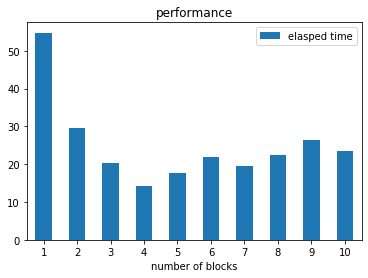

In [183]:
pods = []
times = []
for i in range(1,11):
    pods.append(str(i))
    times.append(times250[i-1][1])

data2 = {"number of blocks":pods, 'elasped time':times};
dataFrame = pd.DataFrame(data=data2)
dataFrame.plot.bar(x="number of blocks", y='elasped time',rot=0, title="performance")

In this experiement we take a fixed number (250) documents and divide it into blocs of size 250/p where p ranges from 1 to 10.  We then run each set of blocs and compute the execution time.  in the first case one pod computes the entire set of 250 docs in 54 seconds.  next two pods working in parallel complete the task in 29 seconds.  The optimal case occurs when 4 pods work in parallel on the 4 blocks. after that the 5 pods suffer scheduling delays trying to execute more tasks than 4.  Recall that we only had 1 cpu per pod.  While 5 pods are available, the endpoint is also running on one of them.

A second question is to look at the average time per inference achieved.

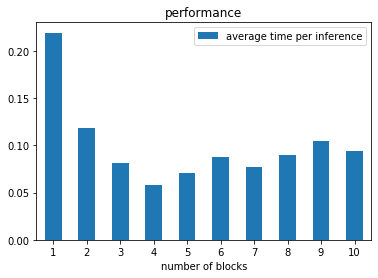

In [185]:
pods = []
times = []
for i in range(1,11):
    pods.append(str(i))
    times.append(times250[i-1][2])

data3 = {"number of blocks":pods, 'average time per inference':times};
dataFrame = pd.DataFrame(data=data3)
dataFrame.plot.bar(x="number of blocks", y='average time per inference',rot=0, title="performance")

Another factor is that every execution of the classify function my load the model.   If the model load time is C and the the rate of each classify operation is r, then for N classification the total time is
$$
t(N) = C + rN
$$
so the average for time for all N is
$$
average(N) ~=~ \frac{t(N)}{N} ~=~ \frac{C}{N} + r
$$
now if the load is divided among p processors in parallel then the time is
$$
t(N/p) ~=~ C+r\frac{N}{p} 
$$
so the average to evaluate N/p items is now
$$
average ~=~ \frac{C}{N} + r\frac{\frac{N}{p}}{N} ~=~ \frac{C}{N} + \frac{r}{p}
$$

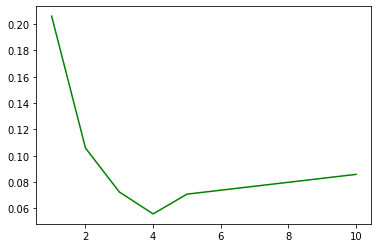

In [213]:
x = [i for i in range(1,11)]
C = 3
r = 0.2
N = 512
def f(p):
    y = C/N+r/p
    if p < 5:
        return y
    else:
        return C/N+r/4 + 0.003*p
    
y = [f(p) for p in range(1,11)]
z = [C+ r*N/p for p in range(1,10)]
plot.plot(x, y, color='green') #, marker='o', linestyle='dashed', linewidth=1, markersize=12)
#plot.plot(x, z)

for fun, let's compute the accuracy for this 250 doc sample.   

In [67]:
correct = 0
for i in range(250):
    if result[0][i] == result[1][i]:
        correct +=1
print(correct,  correct/250)
    

210 0.84


that is good!  (in general it is only 76% on the full test set)

In [87]:
speed = [ times[i]/(lens[i]*(i+1)) for i in range(8)]

In [88]:
speed

[0.18196,
 0.10532,
 0.08164658634538152,
 0.05689516129032258,
 0.07268000000000001,
 0.08626984126984126,
 0.07396825396825397,
 0.0955241935483871]

In [121]:
vals_str = []
vals = []
n = 0
for p in range(130):
    st = '['
    v =[]
    for i in range(20):
        v.append(n+i)
        if i == 0:
            st+=str(n)
        else:
            st+=","+str(n+i)
    st +="]"
    n+=20
    vals.append(v)
    vals_str.append(st)
    print(len(v))
print(len(vals_str))
    

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
130


#### calculating speed-up
we  will use the set  of strings above to calculate the speed-up for various number of processors. In this case we have 130 sets of document ids with each set of length 20.   

In [144]:
vtimes = []
m = 0
p = 2 # we will repeath this calculation for p = 1, 2, 5 and 10 (divisors of 20)
for k in range(130):
    t1 = time.time()
    res_list = []
    for i in range(p):
        res_list.append(fxc.run(vals_str[m+i], endpoint_id=vmendpoint, function_id=go2_function))
    wait = True
    while wait:
        wait = False        
        time.sleep(3)
        for i in range(p):
            wait = wait or fxc.get_task(res_list[i])['pending']
        print(wait)
    t2 = time.time()
    print (fxc.get_result(res_list[0])) 
    print(n,'total time=', t2-t1, 'time per classification =',(t2-t1)/(len(vals[p])*p) ) 
    vtimes.append((len(vals[p-1]), t2-t1, (t2-t1)/(len(vals[p])*p)))
    m+=p


True
False
(array([4, 0, 0, 2, 1, 1, 0, 1, 0, 2, 4, 1, 0, 2, 1, 0, 1, 1, 4, 0],
      dtype=int64), [0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 0, 2, 1, 1, 1, 1, 4, 0])
2600 total time= 7.502154111862183 time per classification = 0.037510770559310916
True
False
(array([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 3, 0, 0, 1, 1],
      dtype=int64), [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 3, 0, 0, 1, 1])
2600 total time= 6.9744133949279785 time per classification = 0.03487206697463989
True
False
(array([0, 0, 4, 1, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
      dtype=int64), [0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0])
2600 total time= 7.08241868019104 time per classification = 0.0354120934009552
True
False
(array([1, 1, 1, 1, 2, 0, 0, 3, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 0],
      dtype=int64), [1, 1, 1, 0, 1, 0, 1, 3, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 0])
2600 total time= 7.056995630264282 time per classification = 0.03528497815132141
True
False
(array([1, 0, 1, 

True
False
(array([0, 3, 0, 0, 2, 2, 2, 1, 2, 1, 3, 0, 2, 2, 2, 2, 1, 0, 2, 0],
      dtype=int64), [0, 3, 2, 1, 2, 2, 2, 1, 2, 1, 3, 0, 2, 2, 2, 2, 1, 0, 2, 0])
2600 total time= 7.059297800064087 time per classification = 0.03529648900032043
True
False
(array([2, 0, 2, 2, 3, 0, 4, 2, 1, 2, 2, 2, 0, 0, 3, 2, 2, 2, 0, 2],
      dtype=int64), [2, 1, 0, 2, 3, 0, 4, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2])
2600 total time= 7.525165319442749 time per classification = 0.037625826597213745
True
False
(array([3, 4, 0, 1, 2, 2, 2, 3, 3, 2, 0, 0, 4, 2, 2, 0, 2, 2, 1, 1],
      dtype=int64), [3, 4, 0, 1, 2, 2, 2, 1, 2, 2, 0, 0, 4, 2, 2, 3, 2, 2, 1, 1])
2600 total time= 7.11717414855957 time per classification = 0.03558587074279785
True
False
(array([2, 2, 1, 2, 2, 0, 0, 0, 1, 2, 1, 2, 0, 4, 3, 0, 4, 2, 2, 1],
      dtype=int64), [2, 2, 1, 2, 2, 0, 0, 3, 1, 2, 1, 2, 0, 4, 2, 0, 4, 2, 2, 1])
2600 total time= 6.942253351211548 time per classification = 0.03471126675605774
True
False
(array([3, 0, 2, 

IndexError: list index out of range

we have previously run this for p = 1, 5, and 10.
below we compute the average time to execute the tasks in parallel

In [145]:
total_times_for_2 = vtimes
#print(total_times_for_10)
#print(total_times_for_5)
#print(total_times_for_1)

In [141]:
l = len(total_times_for_10)
s = total_times_for_10
ave_time = 0
ave_tpi = 0
for i in range(l):
    ave_time+= s[i][1]
    ave_tpi+= s[i][2]
ave_time = ave_time/l
ave_tpi = ave_tpi/l
print(ave_time, ave_tpi)
    

17.080786506334942 0.0854039325316747


In [142]:
l = len(total_times_for_5)
s = total_times_for_5
ave_time = 0
ave_tpi = 0
for i in range(l):
    ave_time+= s[i][1]
    ave_tpi+= s[i][2]
ave_time = ave_time/l
ave_tpi = ave_tpi/l
print(ave_time, ave_tpi)

8.604758759339651 0.04302379379669825


In [143]:
l = len(total_times_for_1)
s = total_times_for_1
ave_time = 0
ave_tpi = 0
for i in range(l):
    ave_time+= s[i][1]
    ave_tpi+= s[i][2]
ave_time = ave_time/l
ave_tpi = ave_tpi/l
print(ave_time, ave_tpi)

6.719360893964767 0.03359680446982384


In [146]:
l = len(total_times_for_2)
s = total_times_for_2
ave_time = 0
ave_tpi = 0
for i in range(l):
    ave_time+= s[i][1]
    ave_tpi+= s[i][2]
ave_time = ave_time/l
ave_tpi = ave_tpi/l
print(ave_time, ave_tpi)

7.170263083775838 0.035851315418879204


we see above the averate time for p=1 is 6.72.   for p = 5 all doing the same task in parallel the time is 6.72, but the total work is 5 times that number.   so speedup is total work/time-to-do-it.

In [147]:
speedup5 = 5*6.72/8.6
speedup5

3.906976744186047

In [151]:
speedup10 = 10*6.72/17.1
speedup10

3.9298245614035086

In [150]:
speedup2 = 2*6.72/7.17
speedup2

1.8744769874476988

In [156]:
import pandas as pd

In [157]:
data = {"number of pods":["1", "2", "5", "10"],
        "speedup":[1, 1.8, 3.9, 3.92]
        };

In [158]:
dataFrame = pd.DataFrame(data=data)

In [159]:
import matplotlib.pyplot as plot

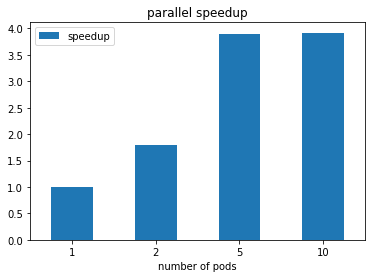

In [178]:
dataFrame.plot.bar(x="number of pods", y="speedup",rot=0, title="parallel speedup")

given 5 pods we see there is no addition speed up beyond 5.  that is to be expected.  and the fact that one pod is also runing the endpoint as well we see we do not go beyond a speedup of 4.